# União das saídas JNose + CK

In [190]:
# Importando as bibliotecas 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [191]:
# Carregando o arquivo 
# O dataset contém 43 colunas: 42 features + label
dataset = pd.read_csv("../Dados/classes-reduced.csv")

# Tratamento da label: No smell (0), AR (1), ET (2), CTL (3), VT (4) 
dataset['CLASS'] = dataset['CLASS'].replace('No smell',0)
dataset['CLASS'] = dataset['CLASS'].replace('AR',1)
dataset['CLASS'] = dataset['CLASS'].replace('ET',2)
dataset['CLASS'] = dataset['CLASS'].replace('CTL',3)
dataset['CLASS'] = dataset['CLASS'].replace('VT',4)

In [192]:
# Substituindo NaNs por media dos valores da coluna
allColumnsWithoutLabel = dataset.columns[:-1]
for column in allColumnsWithoutLabel:
    dataset[column] = dataset[column].fillna(dataset[column].mean())

In [193]:
# Descriptive statistics
dataset.describe()

,cbo,wmc,dit,rfc,lcom,totalMethodsQty,totalFieldsQty,returnQty,loopQty,stringLiteralsQty,loc,comparisonsQty,parenthesizedExpsQty,assignmentsQty,variablesQty,maxNestedBlocksQty,lambdasQty,uniqueWordsQty,CLASS
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,12.536000,5.460000,1.746000,18.374000,8.11000,4.166000,3.456914,1.60800,0.630000,20.388000,47.797595,0.284000,0.17600,12.572000,12.948000,0.618000,0.412000,43.754000,2.00000
std,6.088254,5.654055,1.042909,13.737232,18.55701,4.143523,5.230905,19.52231,1.288573,61.258981,47.000673,0.829892,0.61789,12.890972,12.343501,0.790776,1.342334,26.845014,1.41563
min,2.000000,1.000000,1.000000,1.000000,0.00000,1.000000,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000
25%,8.750000,2.000000,1.000000,10.000000,0.00000,2.000000,0.000000,0.00000,0.000000,2.750000,21.000000,0.000000,0.00000,5.000000,6.000000,0.000000,0.000000,27.000000,1.00000
50%,12.000000,4.000000,2.000000,13.000000,1.00000,3.000000,1.000000,0.00000,0.000000,6.000000,33.000000,0.000000,0.00000,9.000000,9.000000,0.000000,0.000000,36.000000,2.00000
75%,16.000000,7.000000,2.000000,22.000000,6.00000,5.000000,4.000000,1.00000,1.000000,14.000000,58.000000,0.000000,0.00000,15.000000,15.250000,1.000000,0.000000,54.250000,3.00000
max,43.000000,56.000000,10.000000,100.000000,122.00000,37.000000,24.000000,436.00000,8.000000,746.000000,513.000000,8.000000,5.00000,108.000000,100.000000,3.000000,10.000000,236.000000,4.00000


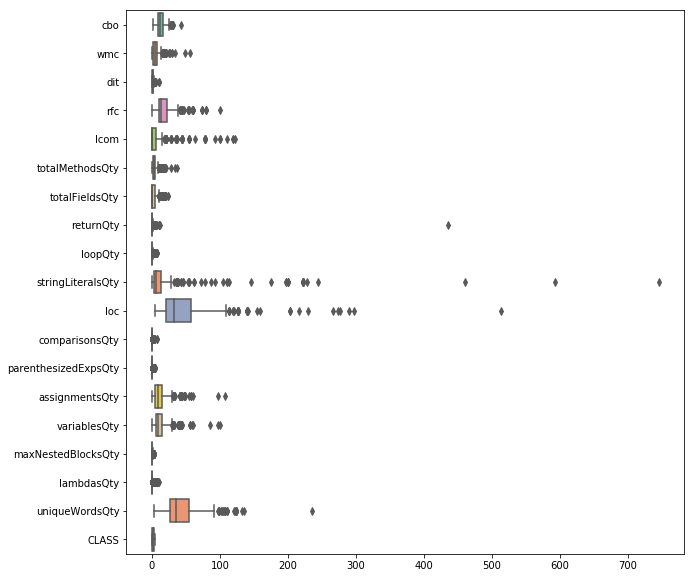

In [194]:
# Boxplot de todo o dataset
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

In [195]:
# Outliers imputation tecnique utilizando outliers do boxplot
def imputation():
    for column in allColumnsWithoutLabel:
        remove_out = np.where(np.in1d(dataset[column], 
                                    boxplot_stats(dataset[column]).pop(0)['fliers']))
        dataset.loc[remove_out[0], column] = dataset[column].mean()

# Imputation Luana
def imputation2():
    for column in allColumnsWithoutLabel:
        outliers_index_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        q3 = dataset[column].quantile(0.9)
        q1 = dataset[column].quantile(0.1)
        print(q3)
        print(q1)
        for i in outliers_index_list[0]:
            instance_value = dataset[column].loc[i]
            if instance_value > q3:
                print(instance_value, "to", q3)
                dataset[column] = dataset[column].replace(instance_value, q3)
            if instance_value < q1:
                dataset[column] = dataset[column].replace(instance_value, q1)

# Imputation considerando substituição de maximo e minimo nos outliers
def imputation3():
    for column in allColumnsWithoutLabel:
        index = 0
        count = 0
        mean = 0

        outliers_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        datasetWithoutOutliers = dataset.drop(dataset.index[[outliers_list]])
        maxValue = datasetWithoutOutliers[column].max() - 1
        minValue = datasetWithoutOutliers[column].min() + 1
        for i in outliers_list[0]:
            instanceValue = dataset.loc[i, column]
            if(instanceValue > maxValue):
                dataset.loc[i, column] = maxValue
            elif(instanceValue < minValue):
                dataset.loc[i, column] = minValue

In [196]:
# Aplicando Imputation
imputation3()

In [197]:
# Estas são as métricas que não estão totalmente balanceadas, por isso acabei removendo, dependendo podemos substituir por outras
dataset = dataset.drop(['comparisonsQty'], axis=1)
dataset = dataset.drop(['parenthesizedExpsQty'], axis=1)
dataset = dataset.drop(['lambdasQty'], axis=1)

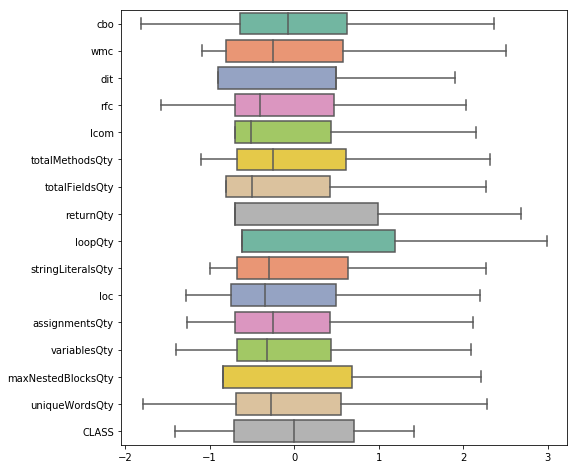

In [198]:
# Normalizando dataset e plotando boxplot novamente
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler().fit(dataset)
scaler = StandardScaler().fit(dataset)
norm_subset = pd.DataFrame(scaler.transform(dataset), columns = dataset.columns)
a = round(norm_subset.describe(), 2)

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.boxplot(data=norm_subset, orient="h", palette="Set2")

In [ ]:
dataset.shape

[Text(0.5, 0, 'cbo'),
 Text(1.5, 0, 'wmc'),
 Text(2.5, 0, 'dit'),
 Text(3.5, 0, 'rfc'),
 Text(4.5, 0, 'lcom'),
 Text(5.5, 0, 'totalMethodsQty'),
 Text(6.5, 0, 'totalFieldsQty'),
 Text(7.5, 0, 'returnQty'),
 Text(8.5, 0, 'loopQty'),
 Text(9.5, 0, 'stringLiteralsQty'),
 Text(10.5, 0, 'loc'),
 Text(11.5, 0, 'assignmentsQty'),
 Text(12.5, 0, 'variablesQty'),
 Text(13.5, 0, 'maxNestedBlocksQty'),
 Text(14.5, 0, 'uniqueWordsQty'),
 Text(15.5, 0, 'CLASS')]

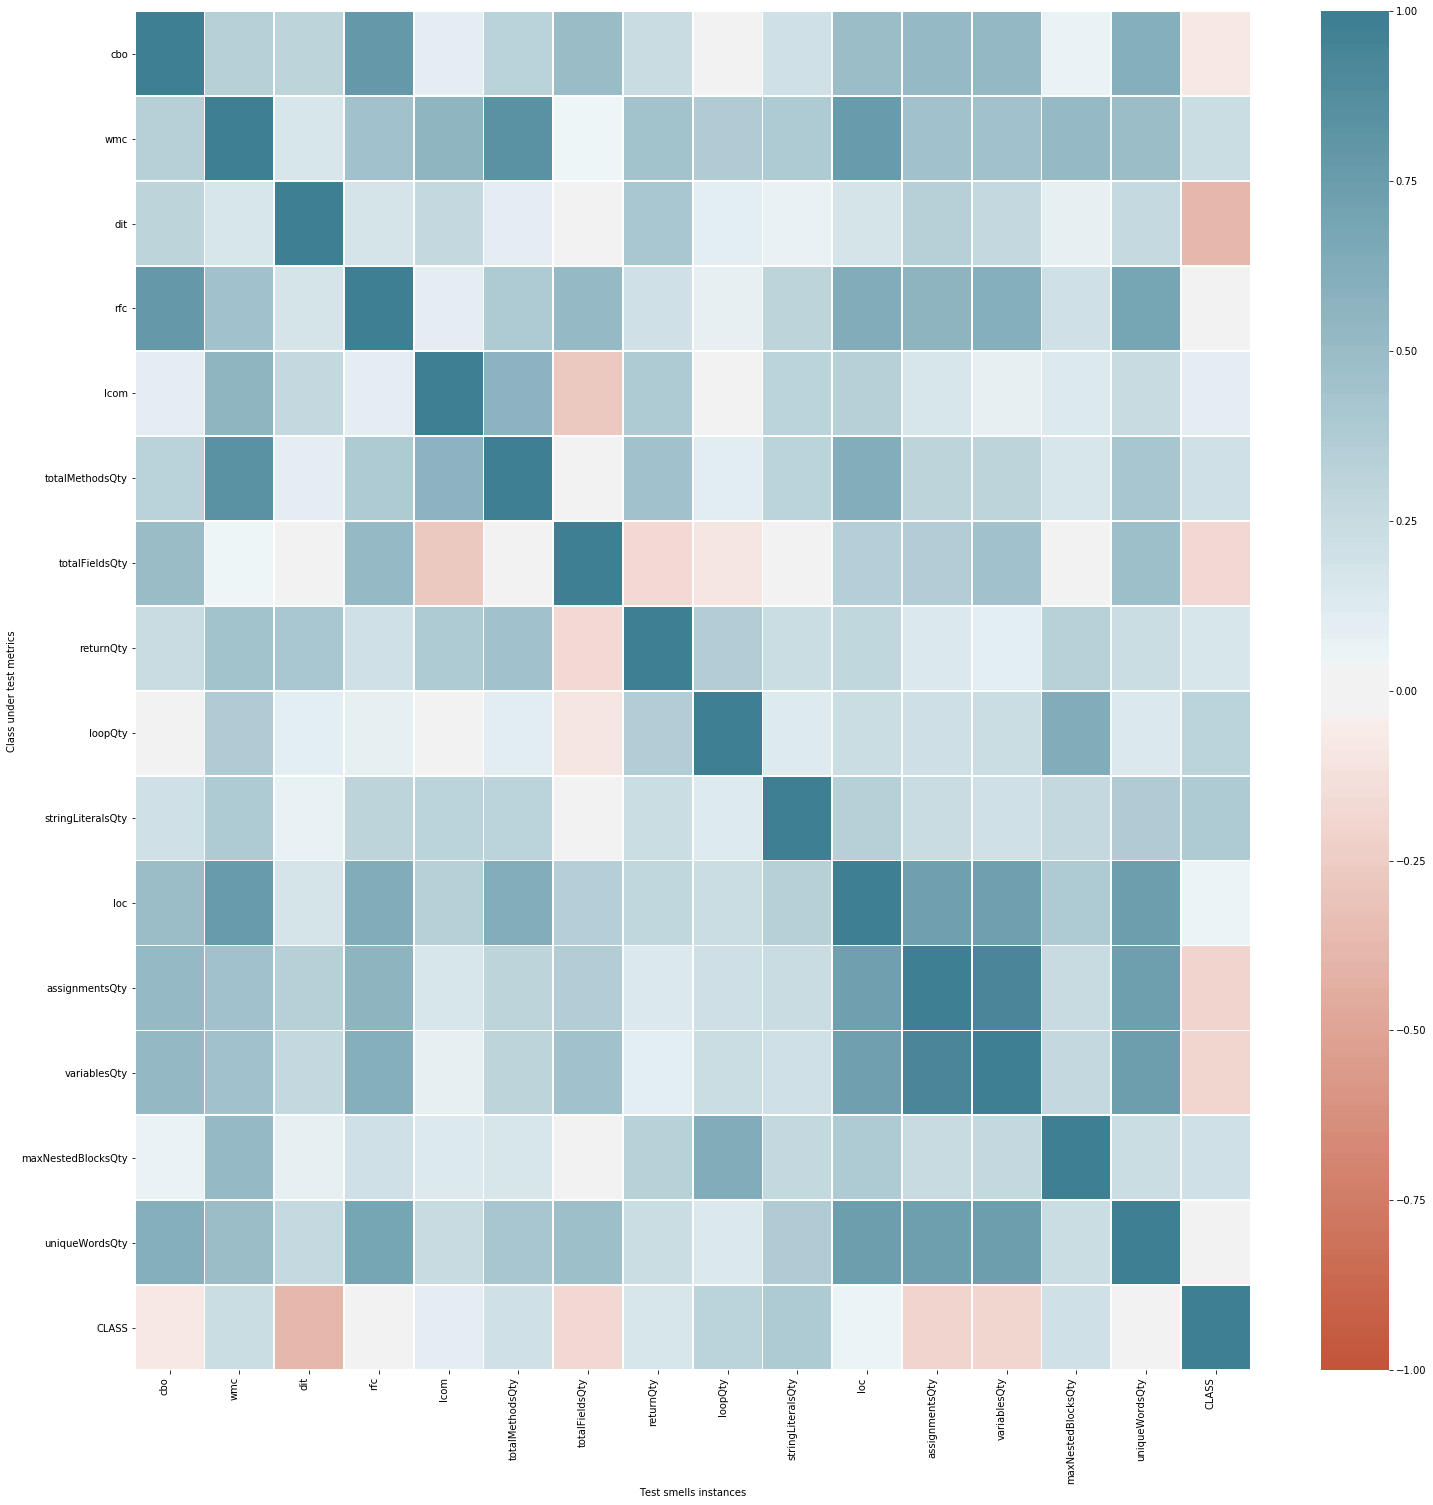

In [200]:
# Só vendo as correlações
#corr = norm_subset.corr(method='spearman').iloc[0:42, 42:]
corr = dataset.corr(method='spearman')

fig, ax = plt.subplots(figsize=(25,25))
    
ax = sns.heatmap(
    corr, 
    linewidths=.8,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=False
)
plt.ylabel('Class under test metrics')
plt.xlabel('Test smells instances')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)